# Initial Conditions Optimization
## Plot History

In [10]:
%matplotlib inline
import matplotlib
matplotlib.font_manager._rebuild()
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.style as style
style.use('fivethirtyeight')
import ray
import io
import os
from IPython.display import display, HTML, Markdown

## Load PlayFair Display and Roboto Fonts from Google

In [11]:
from tempfile import NamedTemporaryFile
import urllib.request
import matplotlib.font_manager as fm

github_url = 'https://github.com/google/fonts/blob/master/ofl/playfairdisplay/static/PlayfairDisplay-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
heading_font = fm.FontProperties(fname=f.name, size=28)

github_url = 'https://github.com/google/fonts/blob/master/ofl/roboto/static/Roboto-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
subtitle_font = fm.FontProperties(fname=f.name, size=20)


## Load Humor Sans Font

In [12]:
github_url = 'http://antiyawn.com/uploads/Humor-Sans-1.0.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
comic_font = fm.FontProperties(fname=f.name, size=18)

# Main code

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

## Load Initial Parameters

In [14]:
dfparam = pd.read_csv("data/param.csv")
display(dfparam)


DRS  start-date  prediction-range         s0  \
0        DRS 01 - Grande São Paulo  2020-03-20               200  2000000.0   
1               DRS 02 - Araçatuba  2020-04-01               200      500.0   
2              DRS 03 - Araraquara  2020-04-01               200     2000.0   
3        DRS 04 - Baixada Santista  2020-04-01               200     8000.0   
4                DRS 05 - Barretos  2020-04-01               200     2000.0   
5                   DRS 06 - Bauru  2020-04-01               200    10000.0   
6                DRS 07 - Campinas  2020-04-01               200    20000.0   
7                  DRS 08 - Franca  2020-04-01               200     1000.0   
8                 DRS 09 - Marília  2020-04-01               200     5000.0   
9              DRS 10 - Piracicaba  2020-04-01               200    10000.0   
10    DRS 11 - Presidente Prudente  2020-04-01               200     1000.0   
11               DRS 12 - Registro  2020-04-01               200     1000.0   
12         DRS 13 - Ribeirão Preto  2020-04-01               200     5000.0   
13  DRS 14 - São João da Boa Vista  2020-04-01               200     2000.0   
14  DRS 15 - São José do Rio Preto  2020-04-01               200    10000.0   
15               DRS 16 - Sorocaba  2020-04-01               200     1200.0   
16                DRS 17 - Taubaté  2020-04-01               200    10000.0   

        e0      a0        i0        r0        d0  START  RATIO  WCASES  WREC  
0   0.0001  0.0001  800.0000  300.0000  400.0000      0   0.15    0.15  0.05  
1   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
2   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
3   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
4   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
5   0.0001  0.0001    4.0000    0.0001    0.0001      0   0.15    0.40  0.10  
6   0.0001  0.0001   40.0000    0.0001    0.0001      0   0.15    0.40  0.10  
7   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
8   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
9   0.0001  0.0001    0.0001    0.0001    1.0000      0   0.15    0.40  0.10  
10  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
11  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
12  0.0001  0.0001    0.0001    0.0001    0.0001      5   0.15    0.40  0.10  
13  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
14  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
15  0.0001  0.0001    2.0000    0.0001    0.0001      0   0.15    0.40  0.10  
16  0.0001  0.0001   17.0000    0.0001    2.0000      0   0.15    0.40  0.10

## Select data set

In [15]:
opt=1

#select history file version, model and states
if opt==0:
    version=105
    model="Yabox"
    DRS=dfparam.DRS

if opt==1:
    version=106
    model="Yabox"
    DRS=dfparam.DRS
    

In [16]:
strFile="results/IC_optimizeddistrictRegions"+str(version)+".csv"
if os.path.isfile(strFile):
    os.remove(strFile)

## Plot and Save Results

# Results for DRS 01 - Grande São Paulo District Region

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
9  2.690156e+08 2020-03-19          137  6387004  2146  375   0.364  0.0353

## 5 Lowest Results

gtot  startdate  startNcases        s0    i0   d0  wcases    wrec
9   2.690156e+08 2020-03-19          137   6387004  2146  375  0.3640  0.0353
63  3.247953e+08 2020-03-20           90   8715675  2574  742  0.3956  0.0357
20  3.342907e+08 2020-03-18           33  18922327  1789  630  0.3786  0.0380
32  3.712186e+08 2020-03-19          136  10210346  1281  371  0.3195  0.0576
2   4.603714e+08 2020-03-20           46  18973049  3805  618  0.4128  0.0585

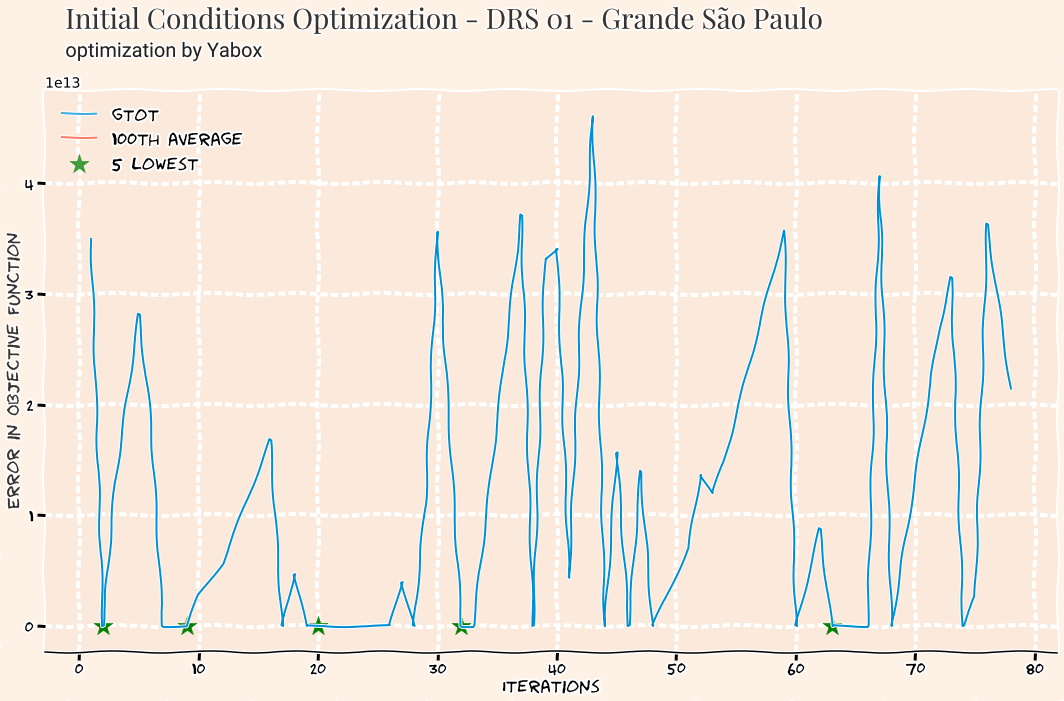

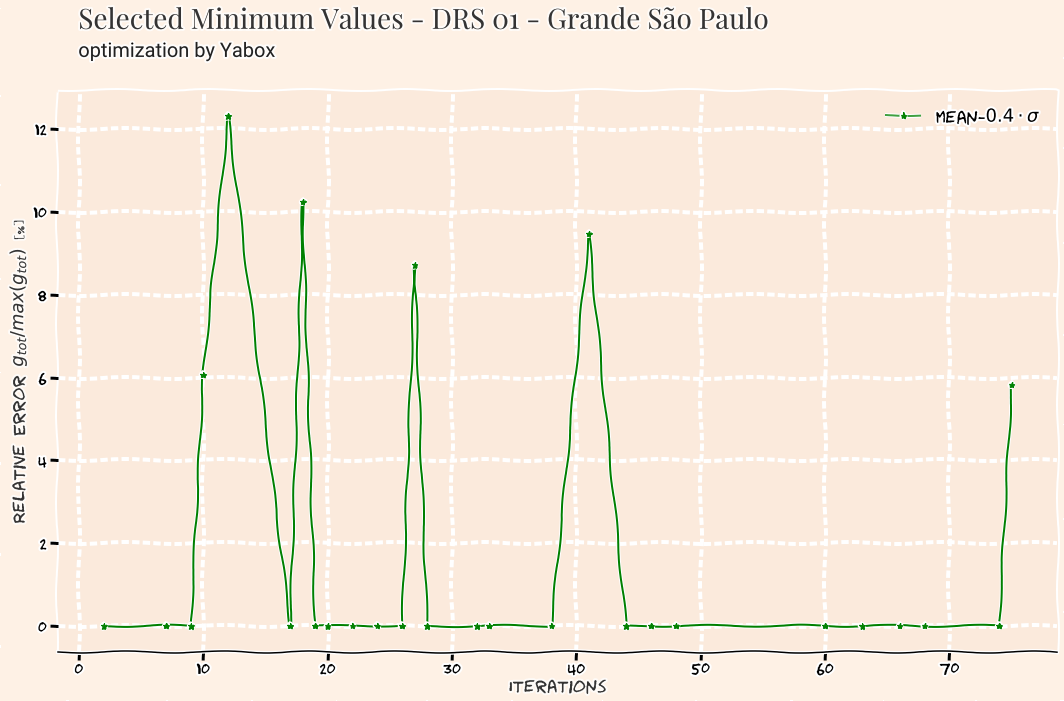

# Results for DRS 02 - Araçatuba District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
105  484317.853944 2020-04-01          101  189200  638  517  0.6112  0.0399

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
105  484317.853944 2020-04-01          101  189200   638  517  0.6112  0.0399
20   682251.547419 2020-03-31           90  135115  1959  615  0.3055  0.0551
90   791664.039871 2020-03-31          142  254783  1707  633  0.5247  0.0628
70   798177.274179 2020-04-01          184  247814  1553  669  0.5041  0.0634
60   798248.227012 2020-03-31          122  645309  3543  605  0.3797  0.0462

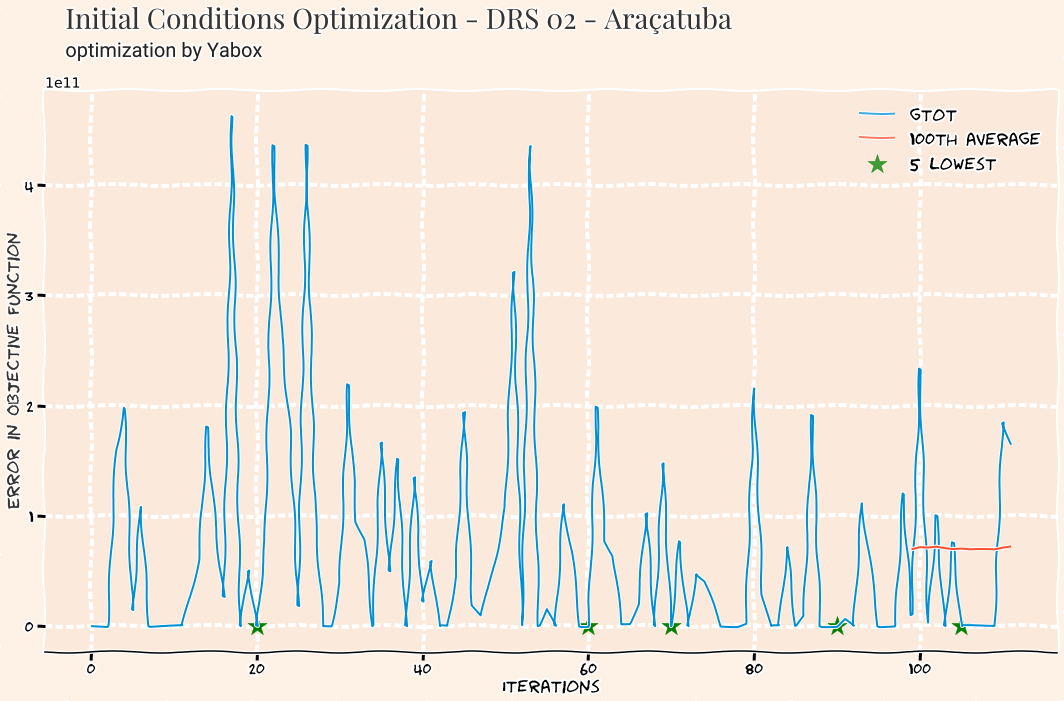

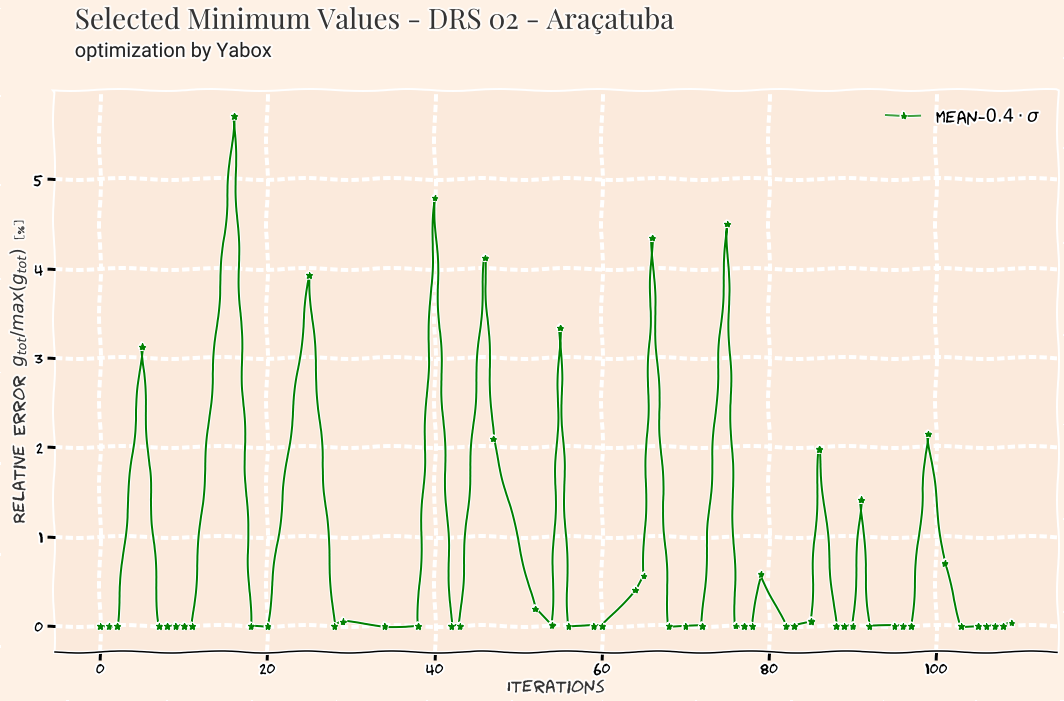

# Results for DRS 03 - Araraquara District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
111  125685.829615 2020-04-01          135  125940  556  10  0.4132  0.0661

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
111  125685.829615 2020-04-01          135  125940   556   10  0.4132  0.0661
106  164080.645230 2020-04-01            4  865381   586  217  0.7214  0.0489
37   198055.384247 2020-03-31          199  419548   825  189  0.6865  0.0507
55   425856.731215 2020-04-02          176  334859  1346  268  0.5810  0.0331
32   535127.363039 2020-03-30           57  665924  1851   80  0.3923  0.0710

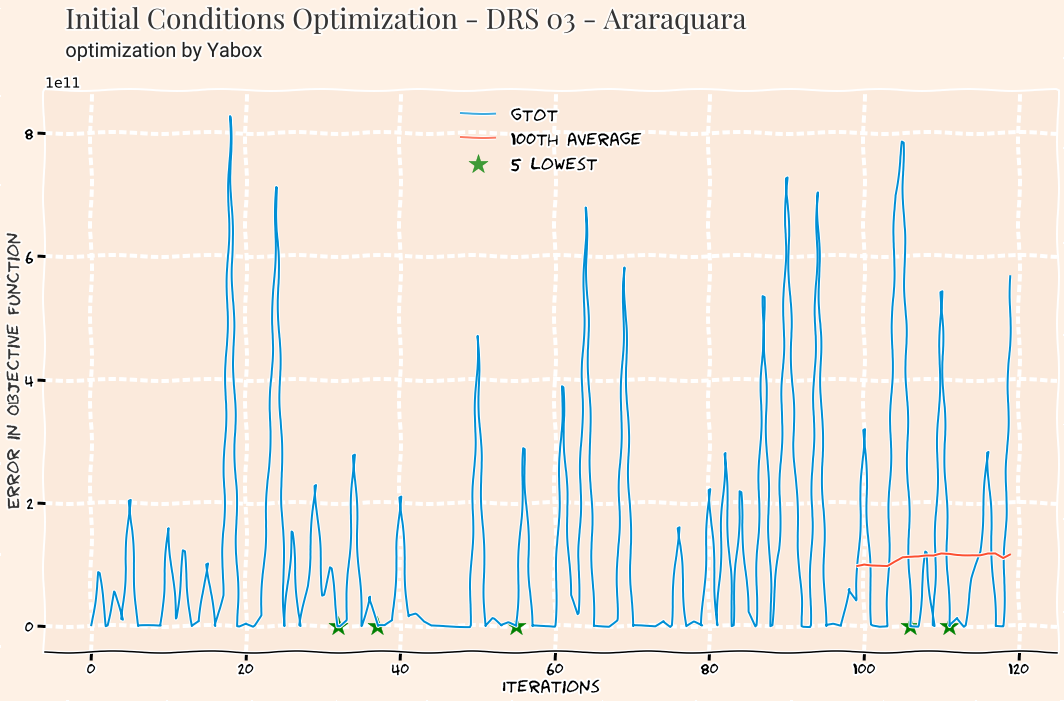

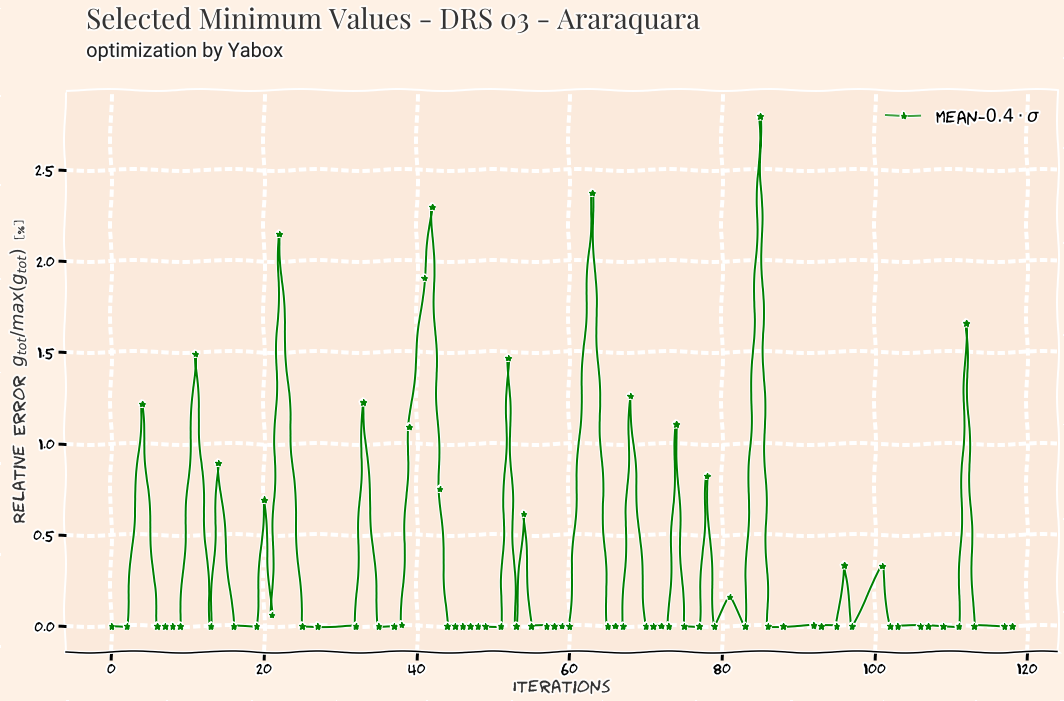

# Results for DRS 04 - Baixada Santista District Region

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
72  981478.11471 2020-04-02           78  543935  2038  895  0.7677  0.0691

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
72  9.814781e+05 2020-04-02           78   543935  2038  895  0.7677  0.0691
48  6.403327e+06 2020-04-02          165   703852  1495  463  0.3246  0.0429
70  7.314876e+06 2020-03-31          238   597028  1548  529  0.5695  0.0325
55  7.365809e+06 2020-04-02           90   490542  3564  575  0.4608  0.0334
57  7.832124e+06 2020-03-31          181  1594676  3151   19  0.5467  0.0667

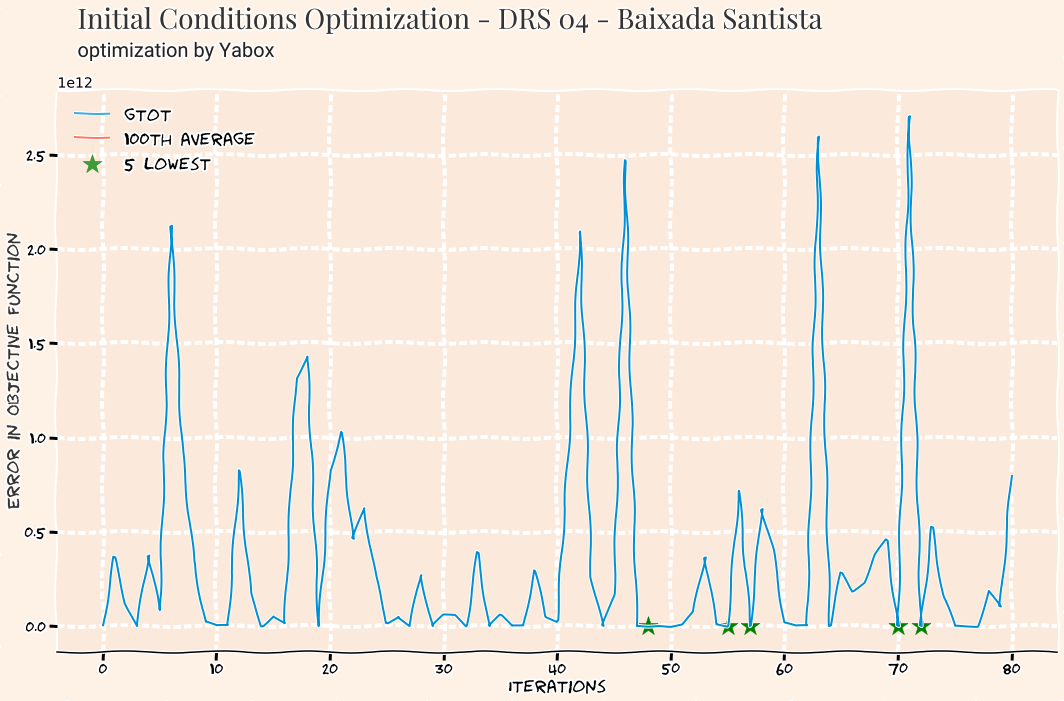

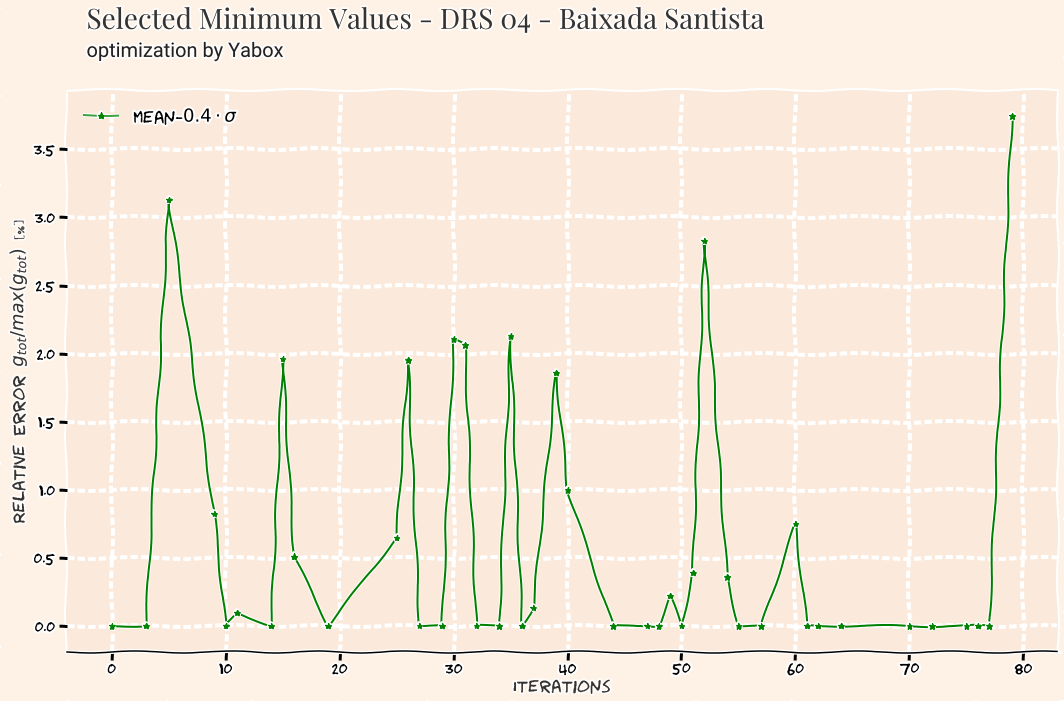

# Results for DRS 05 - Barretos District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
59  93284.869597 2020-04-02          246  330072  446  32  0.4488  0.0382

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
59    93284.869597 2020-04-02          246  330072   446   32  0.4488  0.0382
75   294789.692086 2020-03-31          110  143753  1693   22  0.5500  0.0224
103  375229.772317 2020-03-31          171  367246  1206  371  0.4073  0.0262
32   400873.035306 2020-04-01          187  254436   823  293  0.3570  0.0565
100  452502.105977 2020-03-30          232  196041  1411  161  0.4955  0.0749

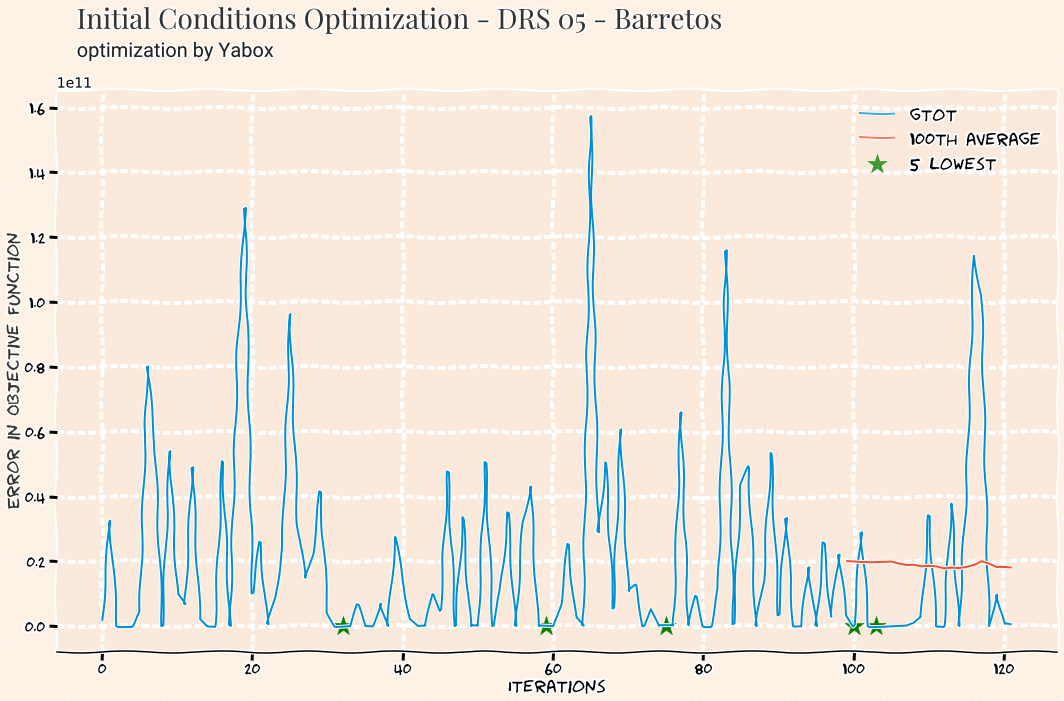

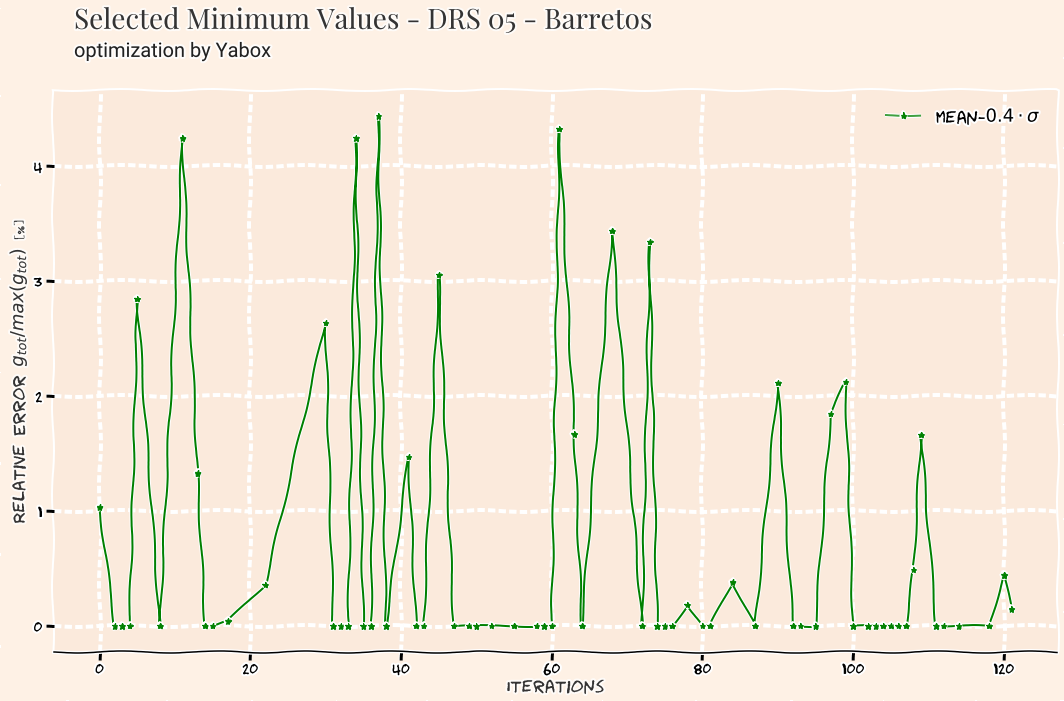

# Results for DRS 06 - Bauru District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
53  539994.156613 2020-03-31          241  857122  543  228  0.6471  0.0287

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
53  5.399942e+05 2020-03-31          241   857122   543  228  0.6471  0.0287
82  1.192765e+06 2020-04-02          208   886284  1311  493  0.3853  0.0705
6   1.506368e+06 2020-03-31           63  1425646  2681  357  0.6293  0.0420
87  1.654774e+06 2020-04-02           65   659904   935  760  0.3876  0.0300
39  5.374945e+06 2020-04-02           52   824719  1789  890  0.3593  0.0694

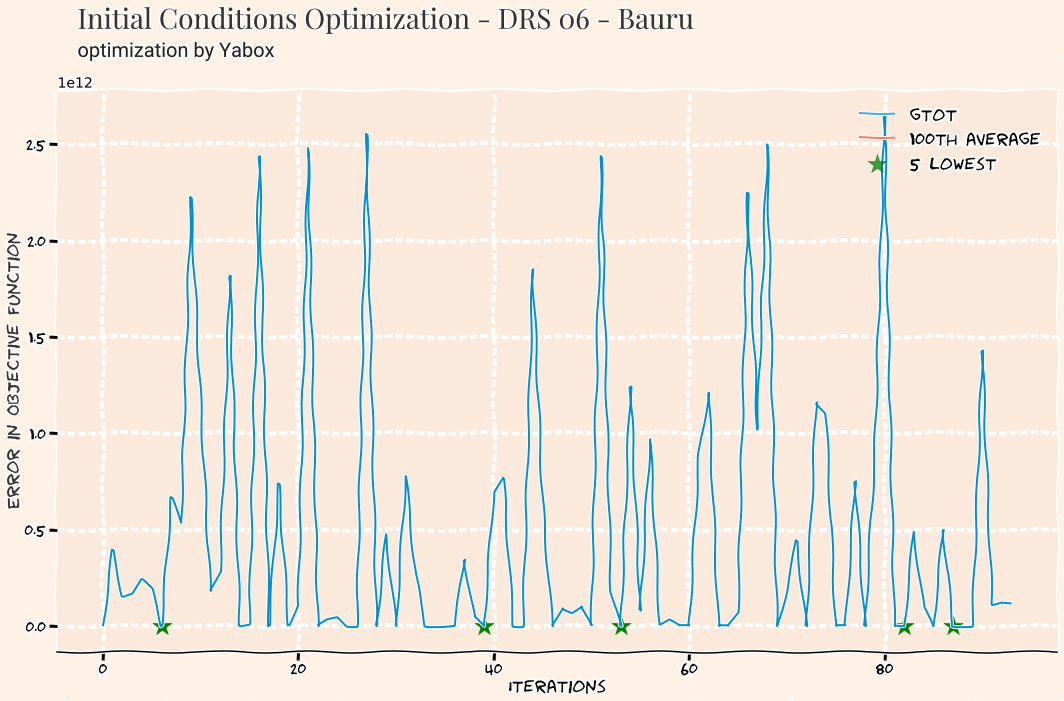

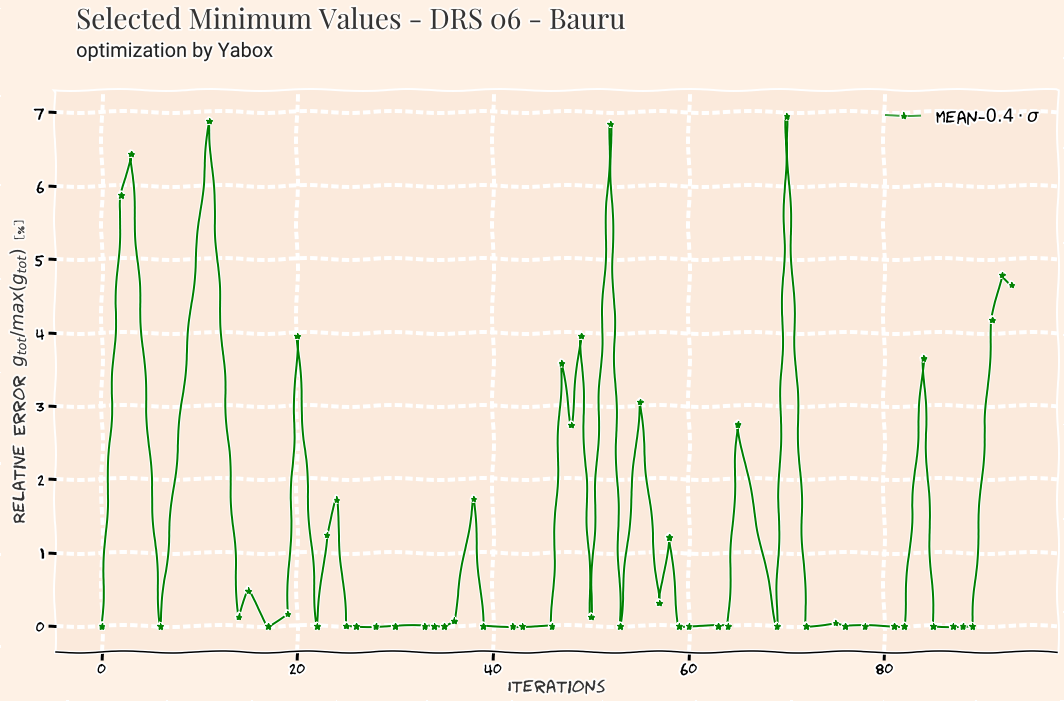

# Results for DRS 07 - Campinas District Region

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
63  3.766531e+06 2020-04-01          204  811781  1043  422  0.4593  0.0444

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
63  3.766531e+06 2020-04-01          204   811781  1043  422  0.4593  0.0444
62  4.757048e+06 2020-03-30            5  2333756  2274  747  0.5936  0.0238
43  6.252879e+06 2020-04-02          210  3792472   816  728  0.3635  0.0683
28  1.080691e+07 2020-04-01          204   811781  2297  422  0.4945  0.0745
60  1.447911e+07 2020-04-02           61  2453141  3984  614  0.6637  0.0692

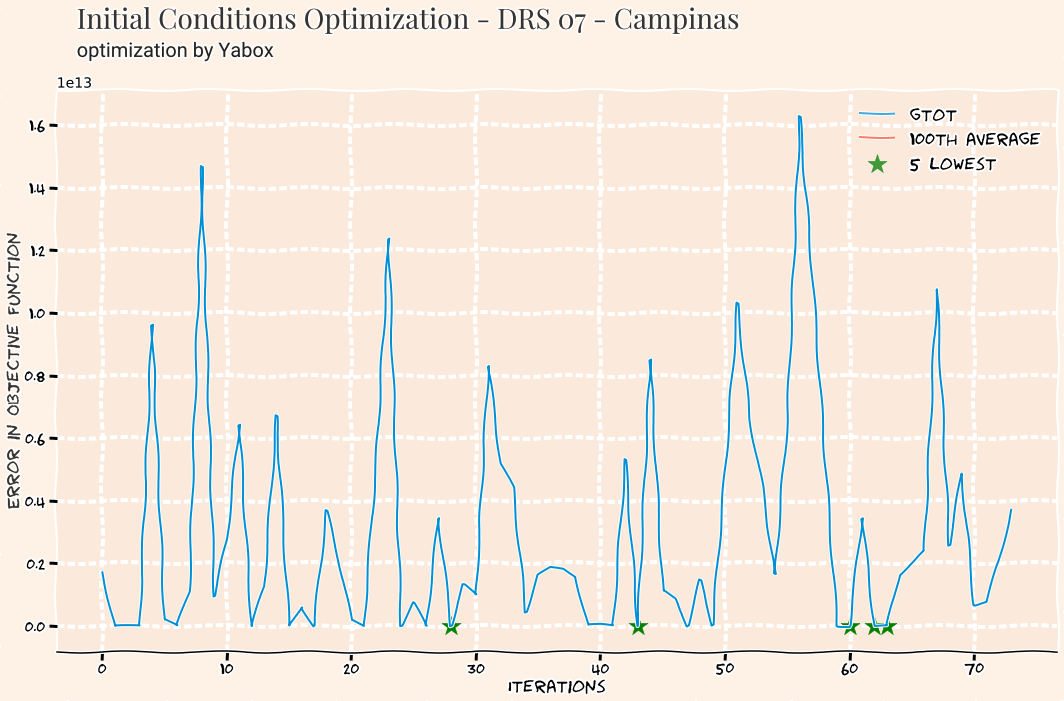

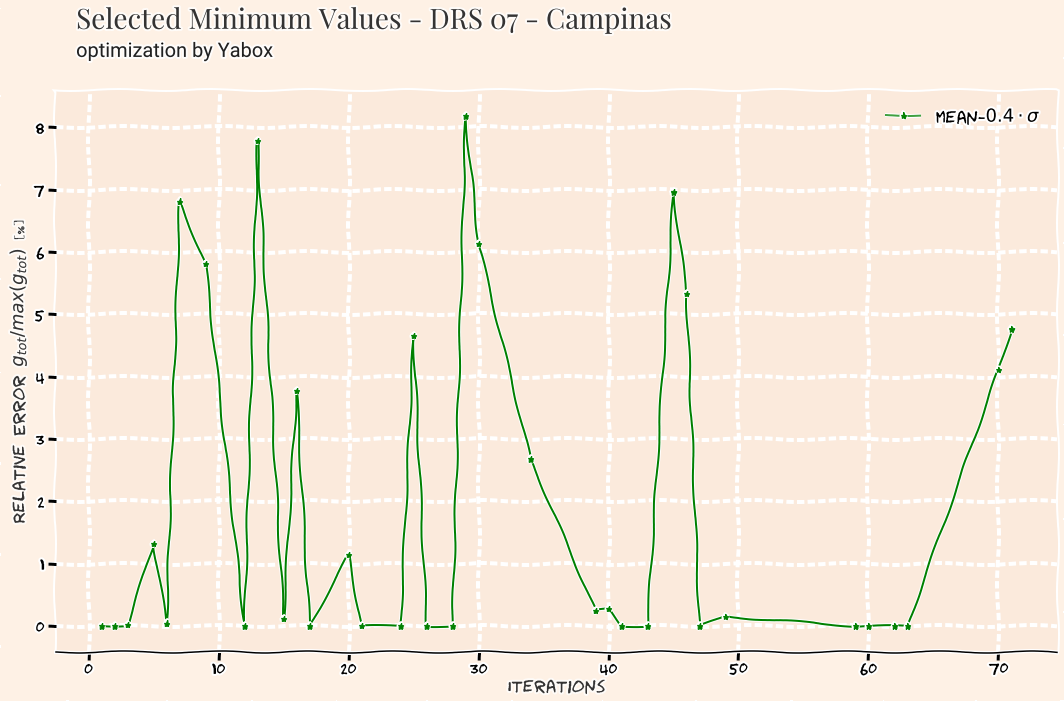

# Results for DRS 08 - Franca District Region

gtot  startdate  startNcases      s0   i0  d0  wcases   wrec
133  126951.410973 2020-03-31           58  251565  587  58  0.4686  0.035

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
133  126951.410973 2020-03-31           58  251565   587   58  0.4686  0.0350
105  165302.058306 2020-04-02          100  634977  1507  172  0.7890  0.0800
131  191757.885381 2020-04-02          213  541461  2074   37  0.6911  0.0725
71   244750.604975 2020-04-01          136  569064   475  244  0.6867  0.0409
101  255284.981802 2020-04-02          126  498723  1356   39  0.7351  0.0773

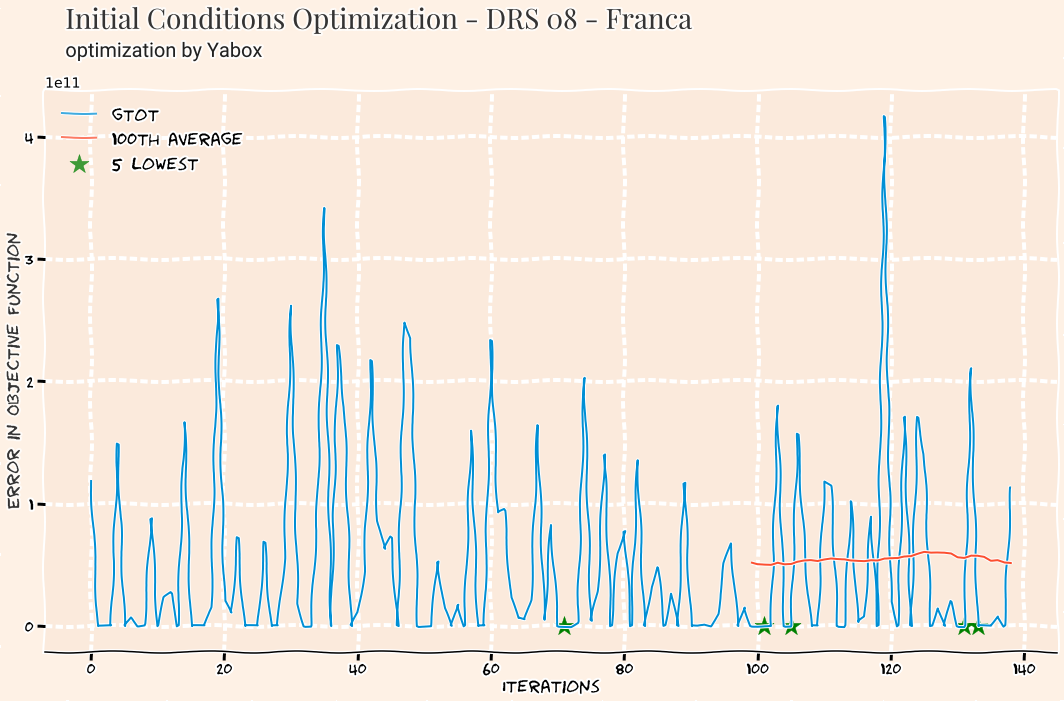

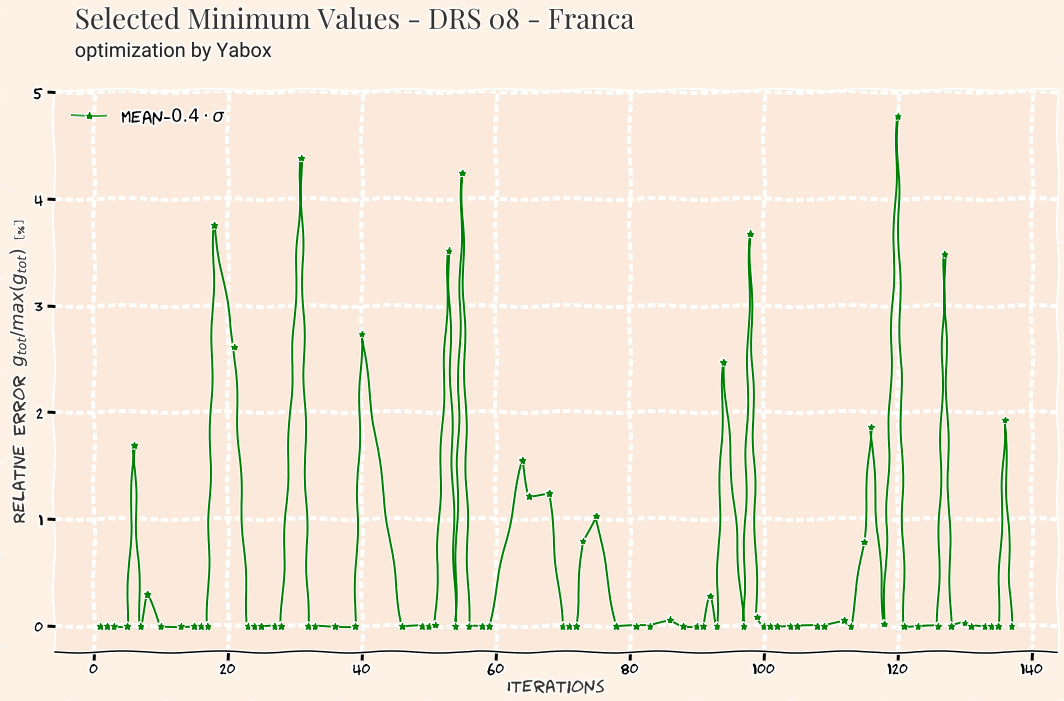

# Results for DRS 09 - Marília District Region

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
0  163233.527582 2020-04-01          196  430205  1045  190  0.6997  0.0578

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
0    163233.527582 2020-04-01          196  430205  1045  190  0.6997  0.0578
51   690059.380224 2020-03-31           68  614325  2558  320  0.7555  0.0780
105  728121.173353 2020-04-01          177  200308  1045  190  0.3189  0.0447
108  833724.601139 2020-04-01          106  438294  1045  927  0.5490  0.0390
98   849442.405039 2020-03-30          133  216483    77  110  0.3290  0.0459

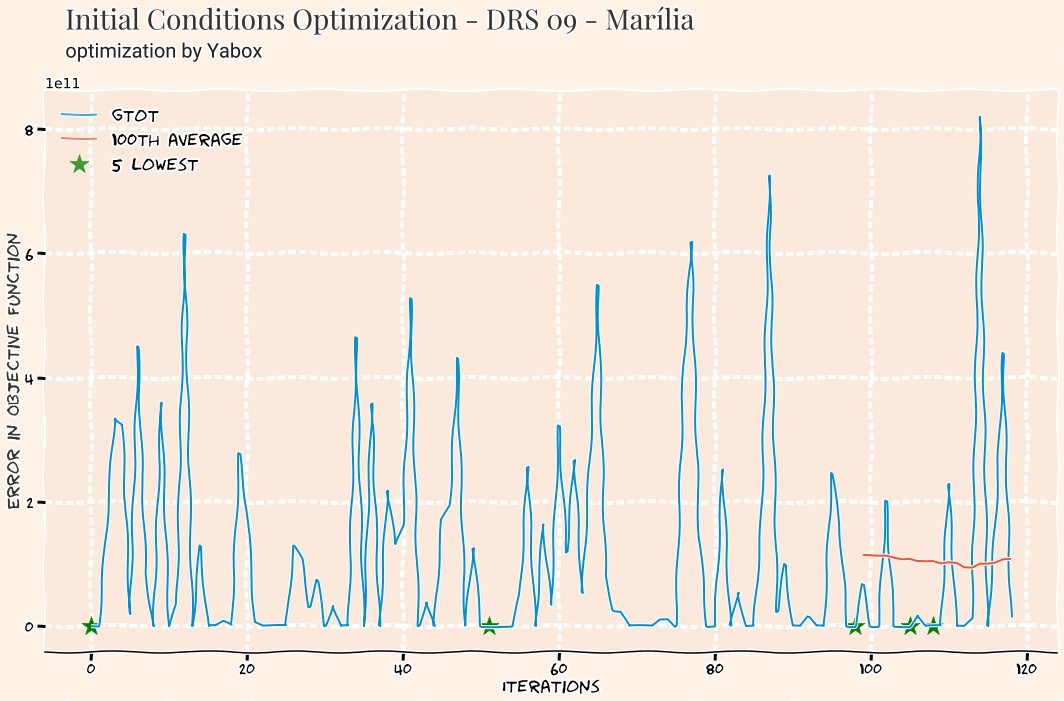

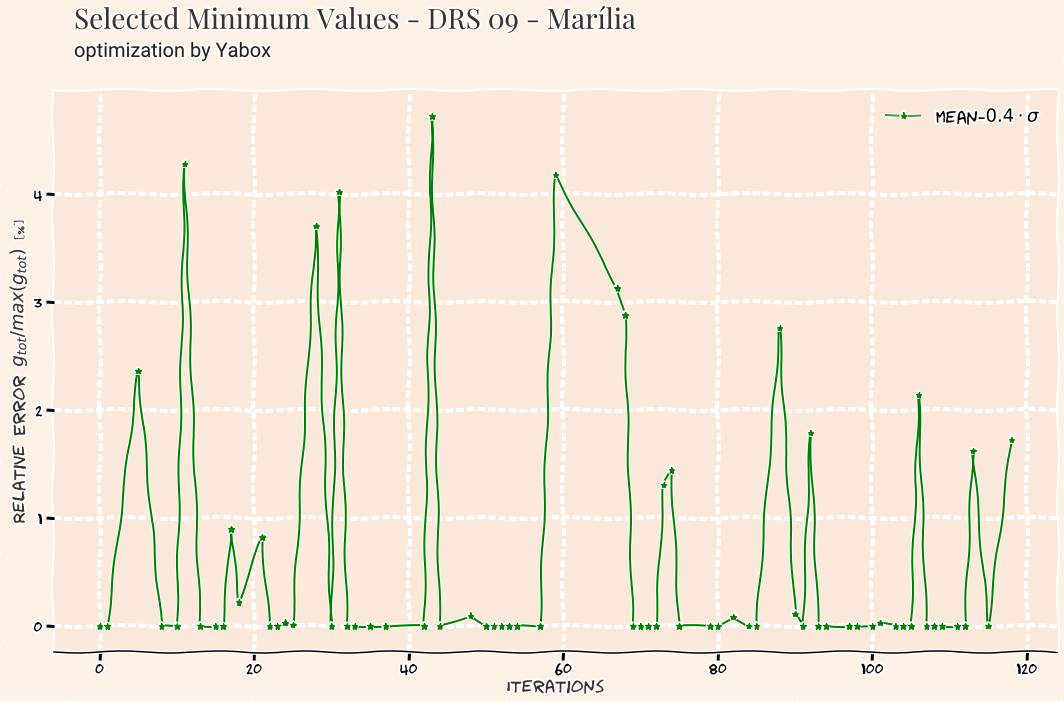

# Results for DRS 10 - Piracicaba District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
24  741385.987899 2020-04-01           49  242229  689  731  0.3904  0.0272

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
24  7.413860e+05 2020-04-01           49   242229   689  731  0.3904  0.0272
91  8.299739e+05 2020-03-31          170   771315   764  636  0.5989  0.0388
72  1.250839e+06 2020-04-01          234   702372  1090  647  0.4474  0.0607
79  1.442523e+06 2020-03-30           82  1354971  1280  232  0.7040  0.0298
14  1.515032e+06 2020-03-31           81   730485  1370  491  0.6110  0.0412

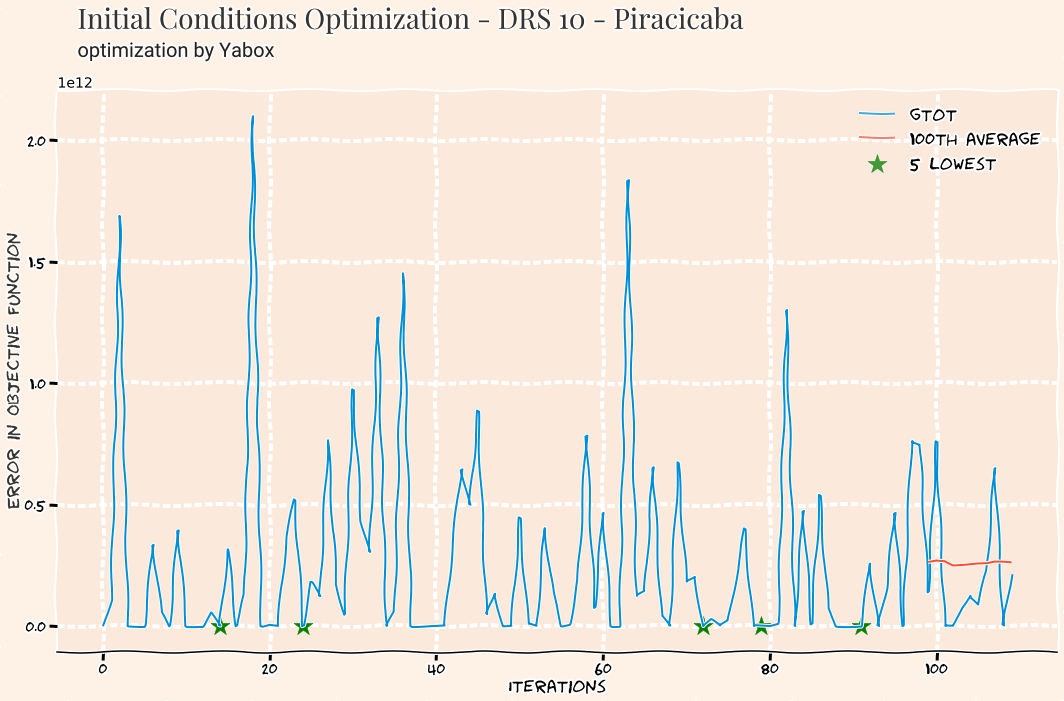

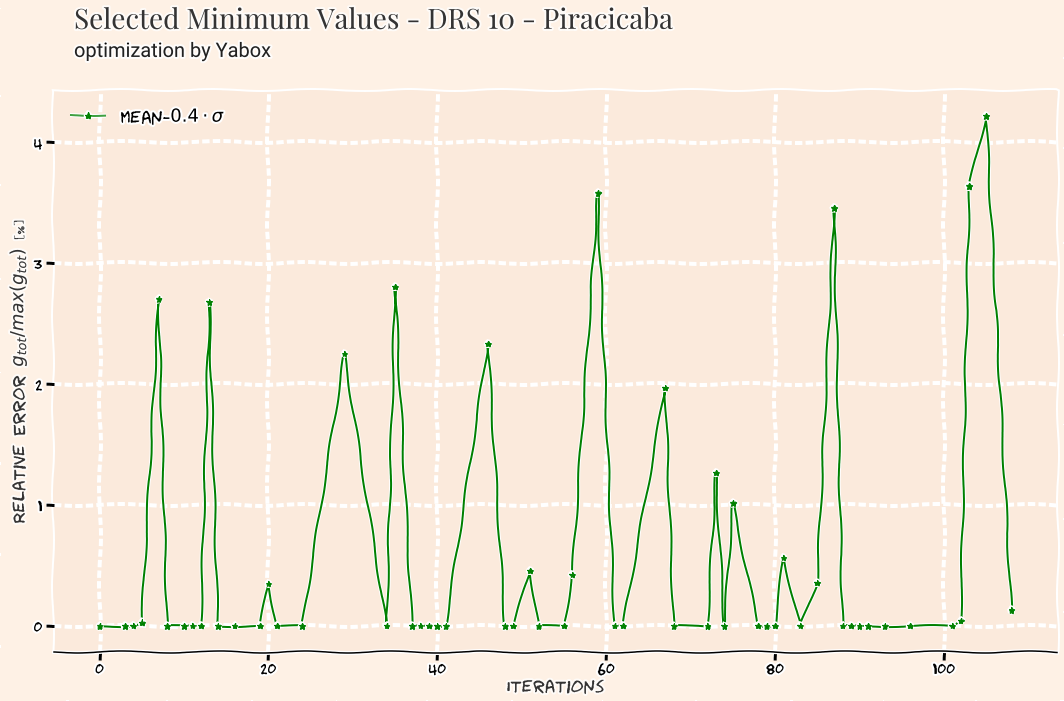

# Results for DRS 11 - Presidente Prudente District Region

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
108  349152.166685 2020-03-31          133  601997  1496  301  0.5567  0.0643

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
108  349152.166685 2020-03-31          133  601997  1496  301  0.5567  0.0643
93   446961.776198 2020-03-31          102  586275   951  456  0.4809  0.0551
7    466979.894047 2020-03-31           14  273869  1765  366  0.7171  0.0429
89   493233.373232 2020-04-01          246  568275  1938  451  0.6718  0.0350
79   586211.020929 2020-03-31           88  439891  1101  205  0.4875  0.0748

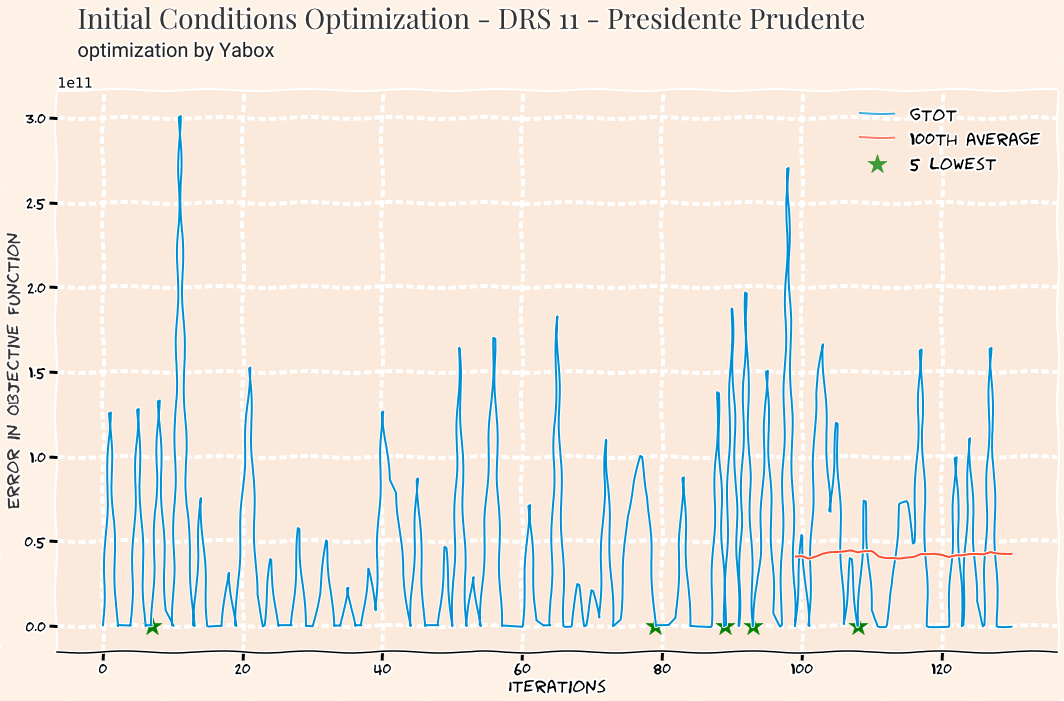

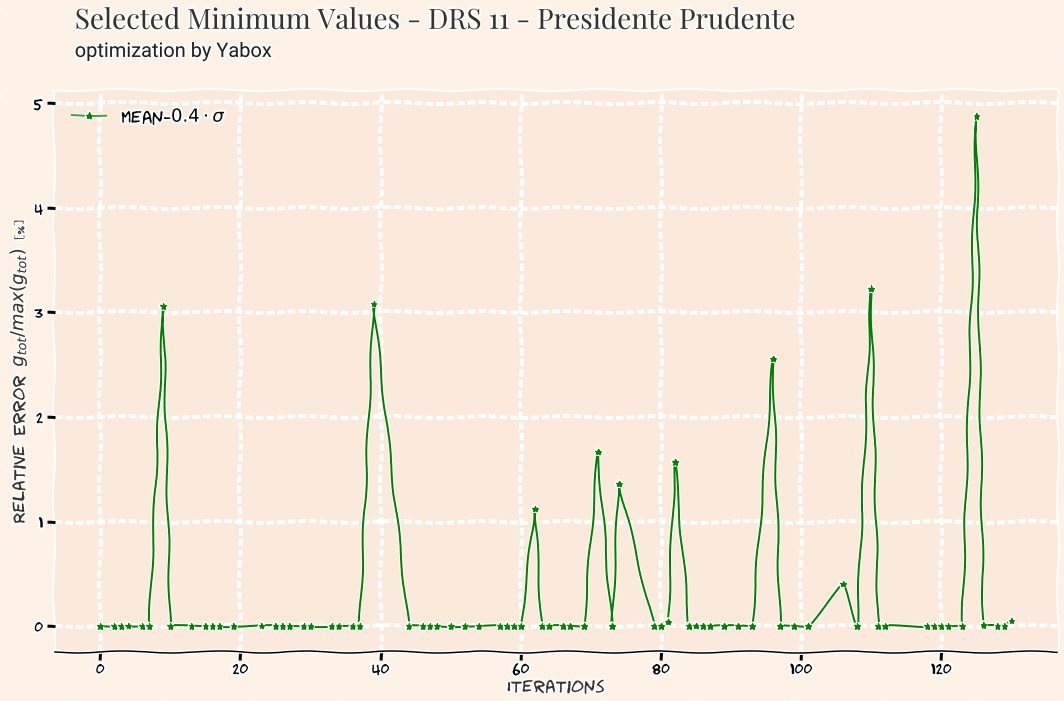

# Results for DRS 12 - Registro District Region

gtot  startdate  startNcases     s0   i0  d0  wcases    wrec
114  38907.504339 2020-03-30           77  82654  149  73   0.373  0.0433

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
114   38907.504339 2020-03-30           77   82654   149   73  0.3730  0.0433
104  106511.353944 2020-04-02           24  253338   324  356  0.6061  0.0713
10   130816.701858 2020-04-01          157  147727   856  968  0.3217  0.0533
89   169339.518286 2020-03-30           21   46143   928  147  0.4006  0.0468
71   177585.969931 2020-04-02           76   37442  1334  182  0.7916  0.0459

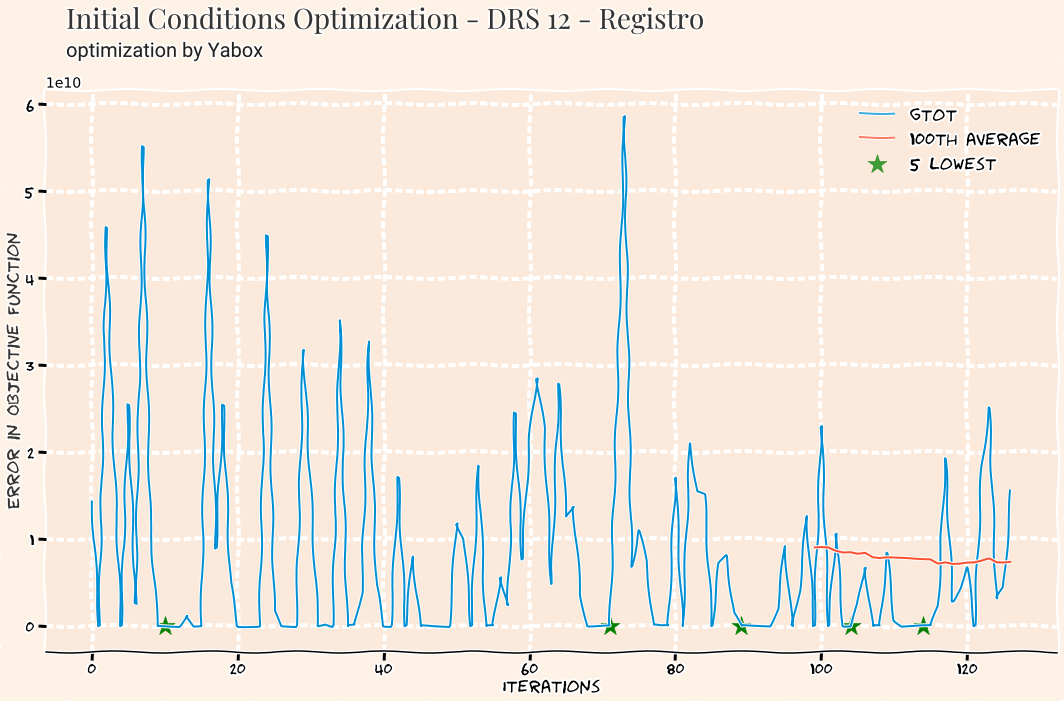

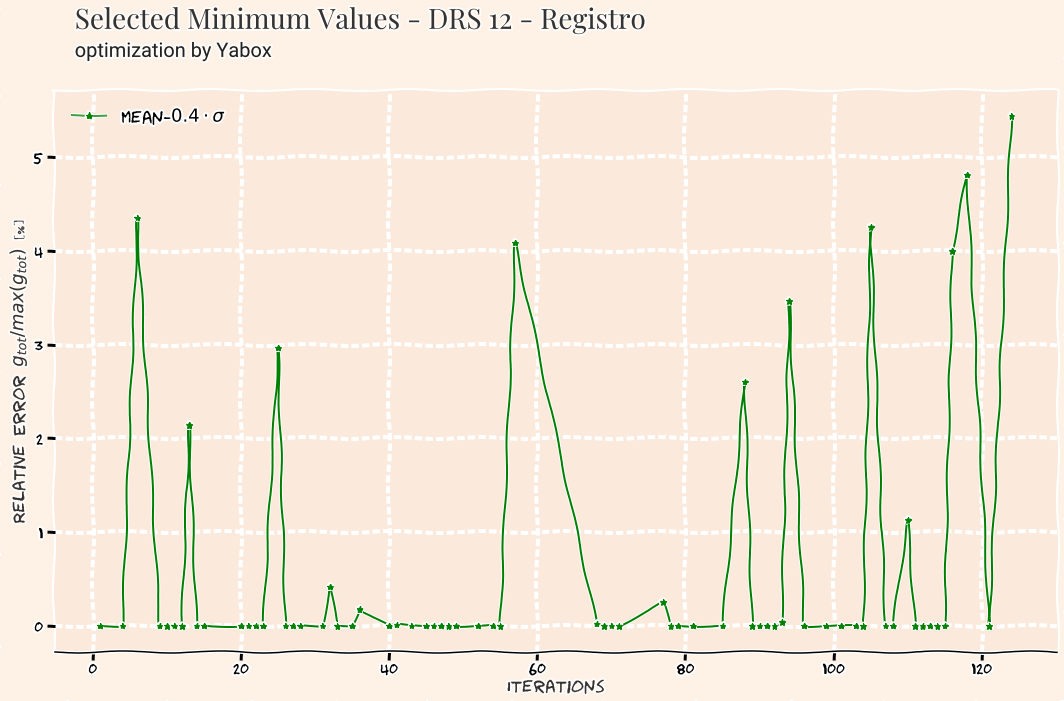

# Results for DRS 13 - Ribeirão Preto District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
94  477698.462281 2020-04-02          221  695245  527  92  0.4093  0.0316

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
94  4.776985e+05 2020-04-02          221   695245   527   92  0.4093  0.0316
63  7.686082e+05 2020-04-01          225   453529  1744  505  0.6944  0.0273
35  9.836073e+05 2020-03-31           48   199851  1026  164  0.5708  0.0781
36  1.126649e+06 2020-04-02          239  1258684   642  534  0.3173  0.0577
11  1.234798e+06 2020-04-01          174   499911  1498  566  0.4078  0.0559

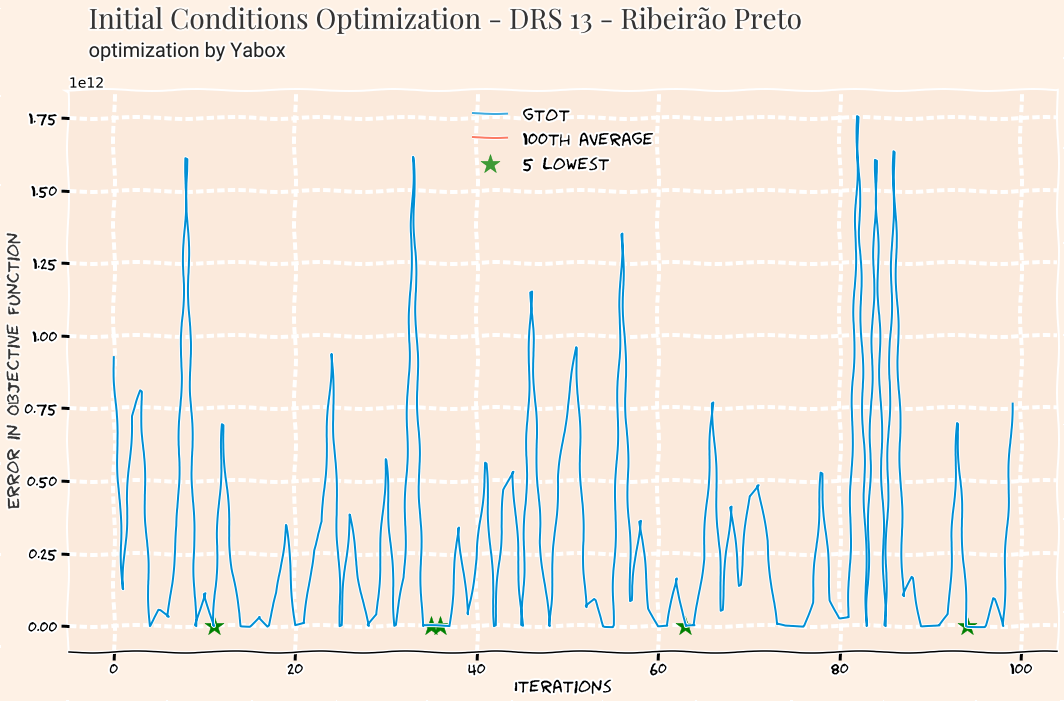

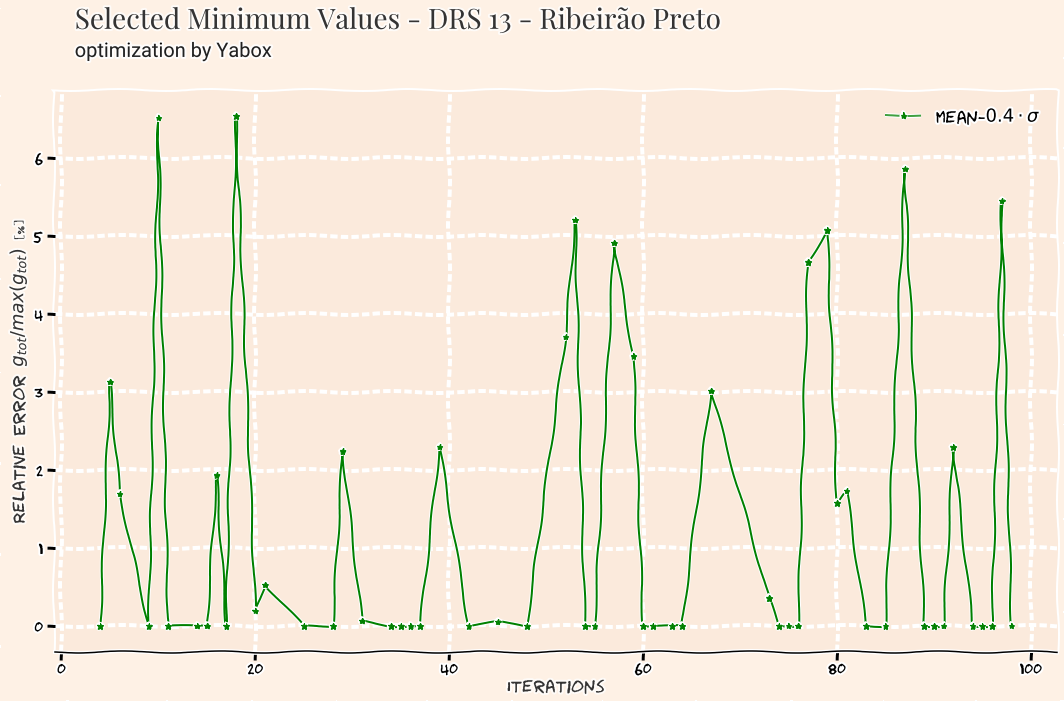

# Results for DRS 14 - São João da Boa Vista District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
89  135896.807867 2020-04-02          219  235223  369   9  0.4843  0.0734

## 5 Lowest Results

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
89  135896.807867 2020-04-02          219  235223   369    9  0.4843  0.0734
25  211270.734827 2020-03-31           76  702243  1206  182  0.6566  0.0672
37  234678.359458 2020-04-01          208  608651  1373  284  0.7186  0.0637
38  246670.393435 2020-03-31          159  555370  1421  135  0.6276  0.0216
76  267137.512817 2020-03-31          108  266080  1257  125  0.3880  0.0733

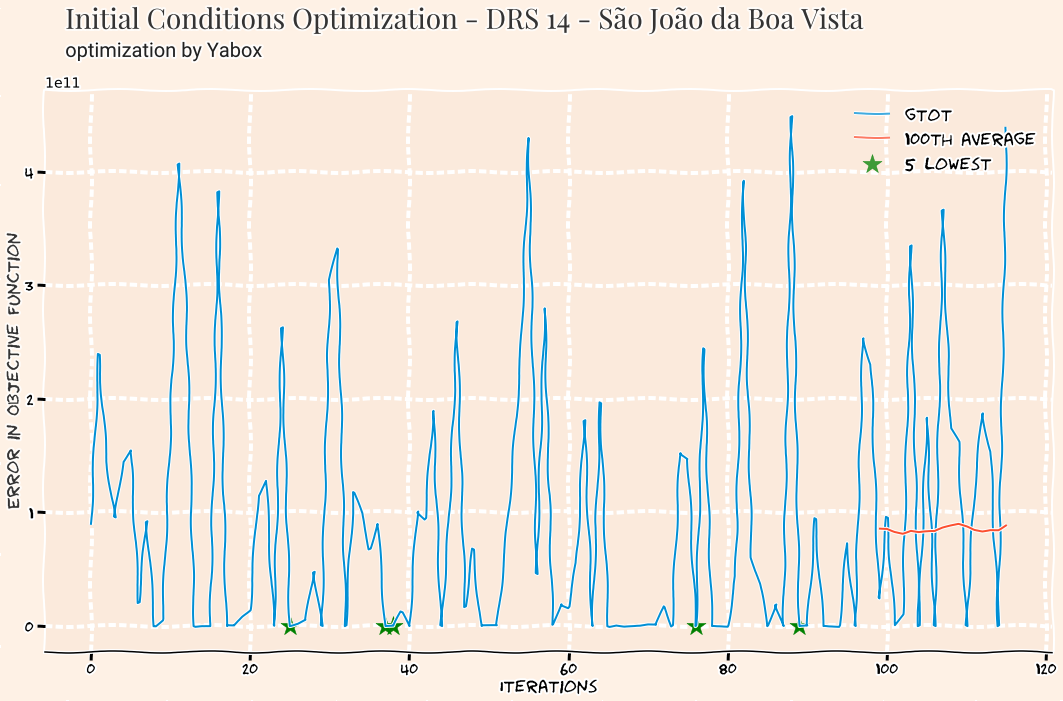

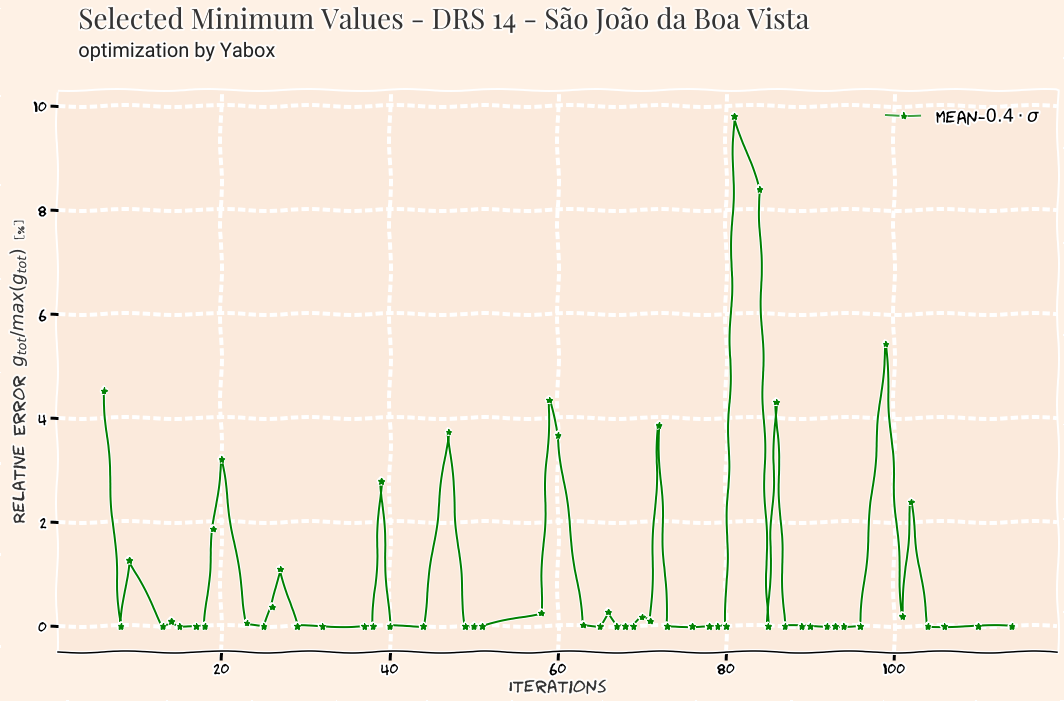

# Results for DRS 15 - São José do Rio Preto District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
8  608447.56837 2020-04-02          163  703328  672  194  0.4658  0.0631

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
8   6.084476e+05 2020-04-02          163   703328   672  194  0.4658  0.0631
43  7.881484e+05 2020-03-30          163   703328   860  314  0.4658  0.0631
92  8.454619e+05 2020-03-31           73   656811  2860  485  0.4140  0.0201
98  1.222600e+06 2020-04-02           31   533846  3054  438  0.5019  0.0770
52  1.450080e+06 2020-03-30           47  1086409  2328  420  0.5956  0.0493

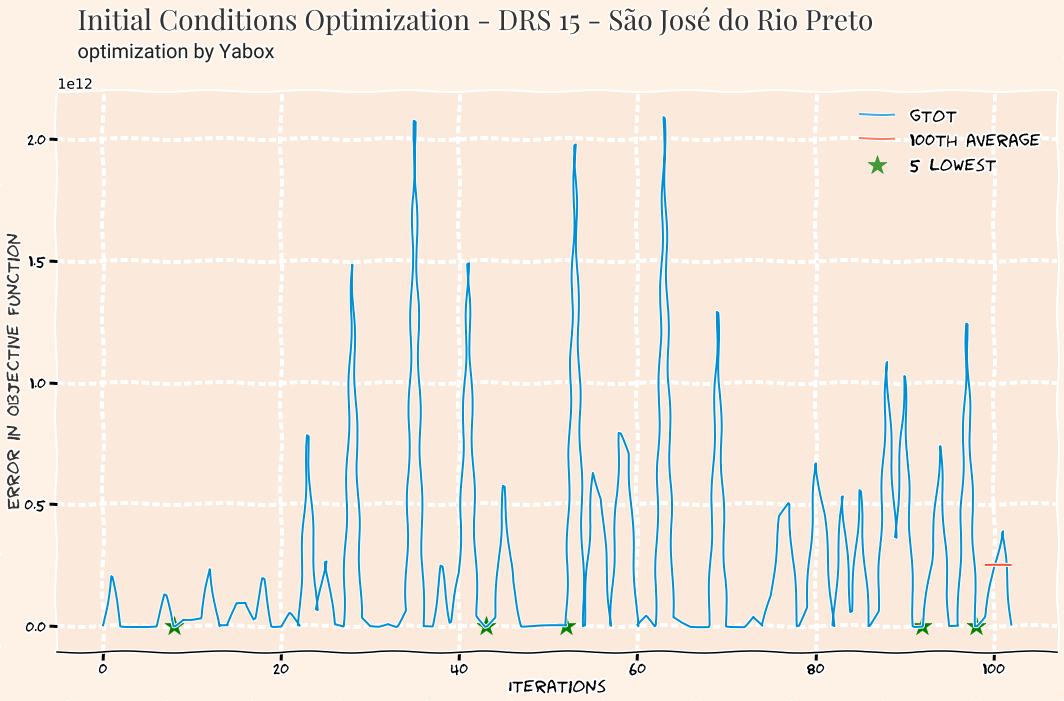

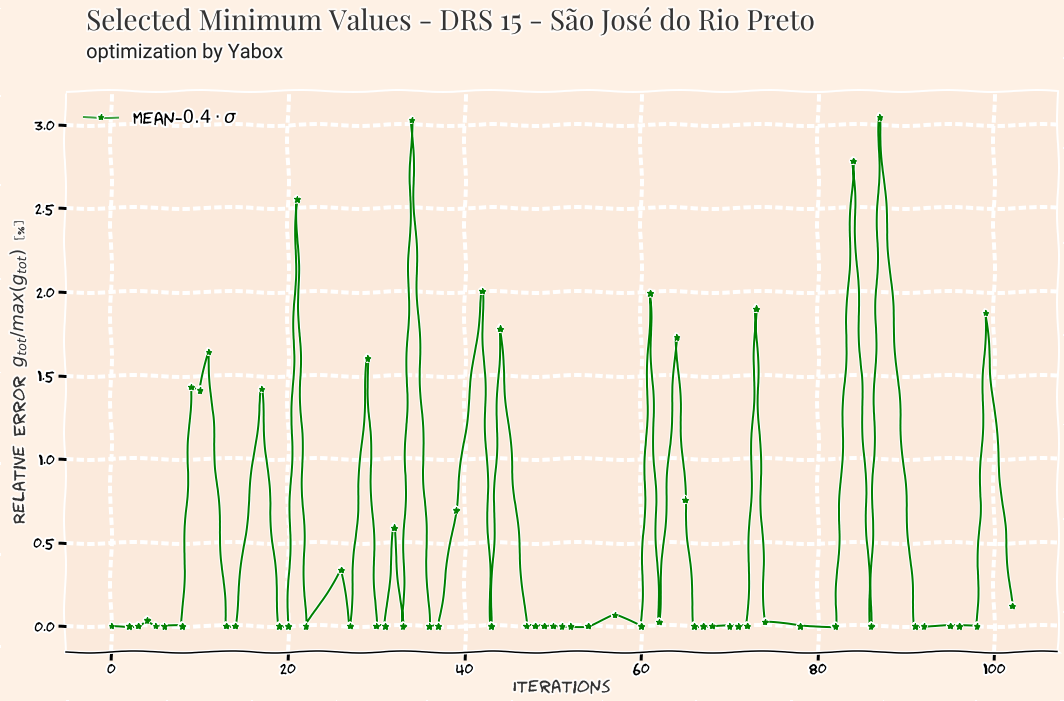

# Results for DRS 16 - Sorocaba District Region

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
7  1.471188e+06 2020-03-30          166  2002778  1556  113  0.3893  0.0252

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
7   1.471188e+06 2020-03-30          166  2002778  1556  113  0.3893  0.0252
2   2.502639e+06 2020-04-02          213   281392  3877  541  0.6134  0.0636
35  4.534987e+06 2020-03-31          177   621404  3103  504  0.3683  0.0232
69  4.568795e+06 2020-03-30          180   837729  3847  687  0.6034  0.0617
77  1.389699e+07 2020-04-02          201  1310246  2812   28  0.3476  0.0456

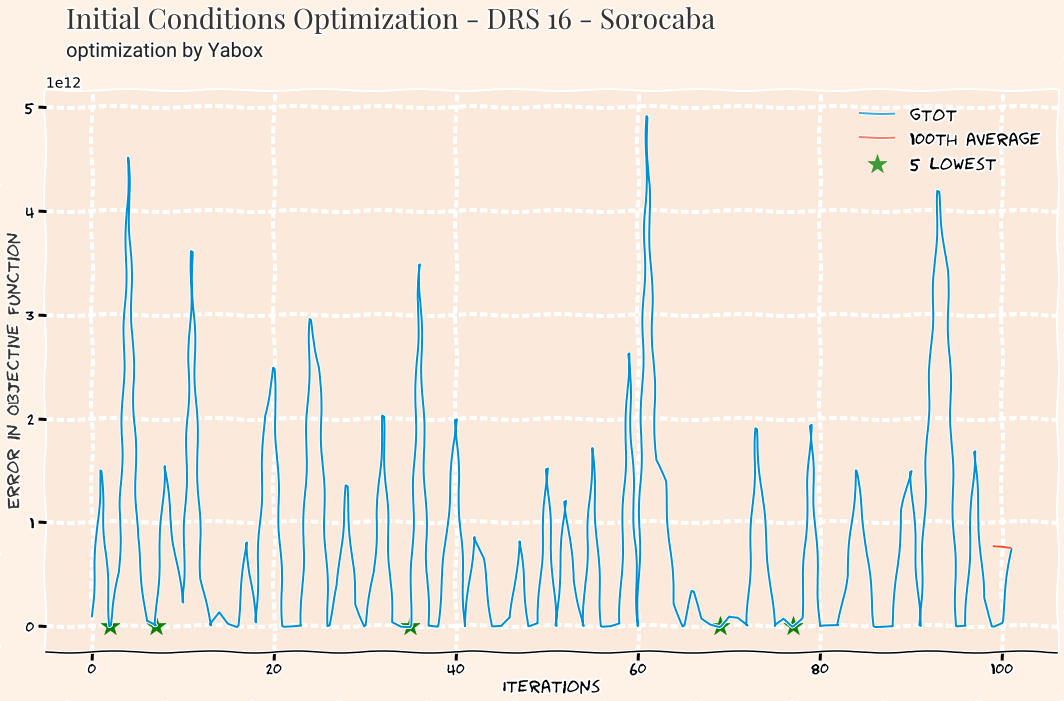

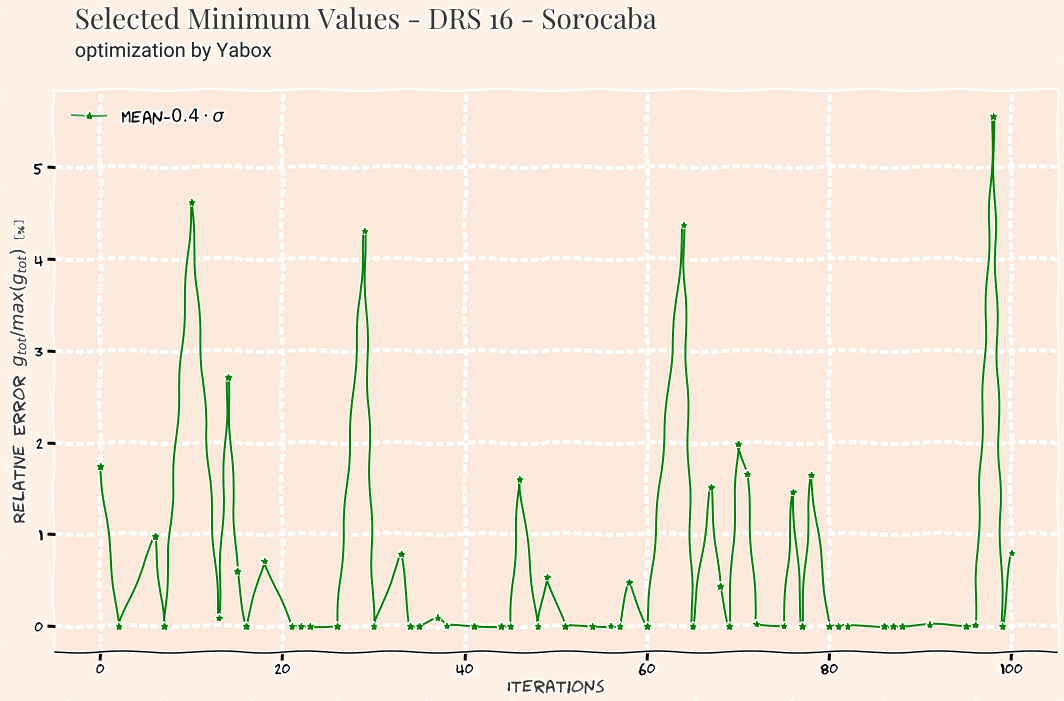

# Results for DRS 17 - Taubaté District Region

gtot  startdate  startNcases      s0    i0   d0  wcases    wrec
33  1.159645e+06 2020-04-02            9  368172  2318  117  0.7287  0.0711

## 5 Lowest Results

gtot  startdate  startNcases       s0    i0   d0  wcases    wrec
33  1.159645e+06 2020-04-02            9   368172  2318  117  0.7287  0.0711
67  1.838620e+06 2020-03-30          108   424517  1886  821  0.4705  0.0338
18  4.252526e+06 2020-03-30           14  1844720  1876  672  0.3700  0.0798
40  5.621686e+06 2020-03-31           44   300420  2400  387  0.3229  0.0338
75  6.962288e+06 2020-04-01           44   470095  2400  387  0.3229  0.0732

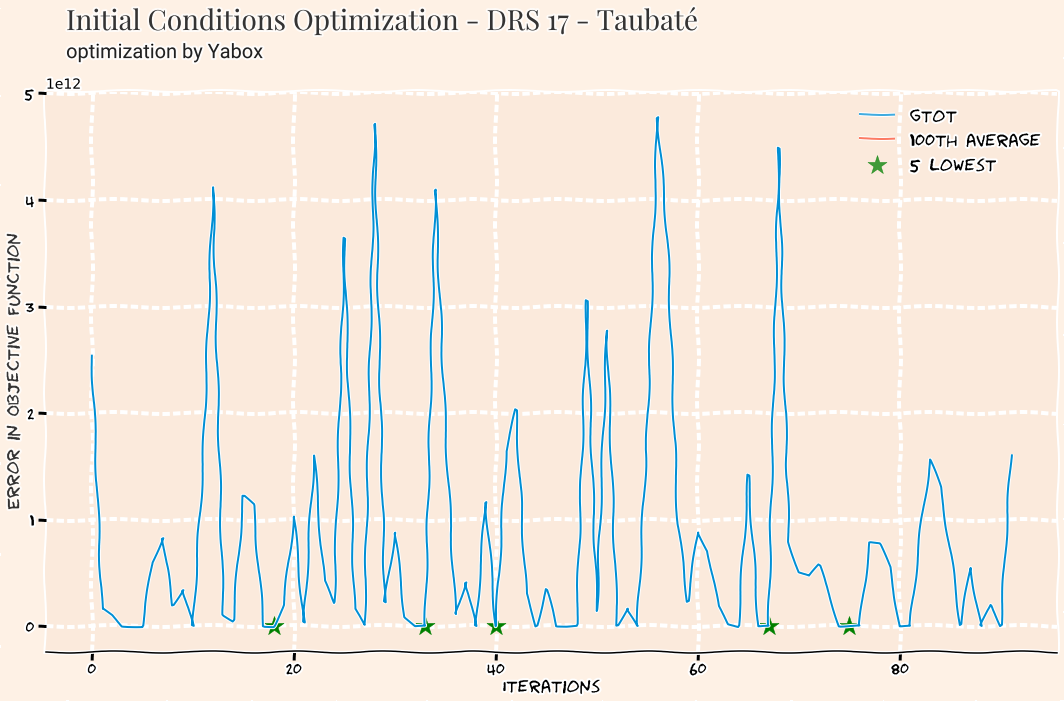

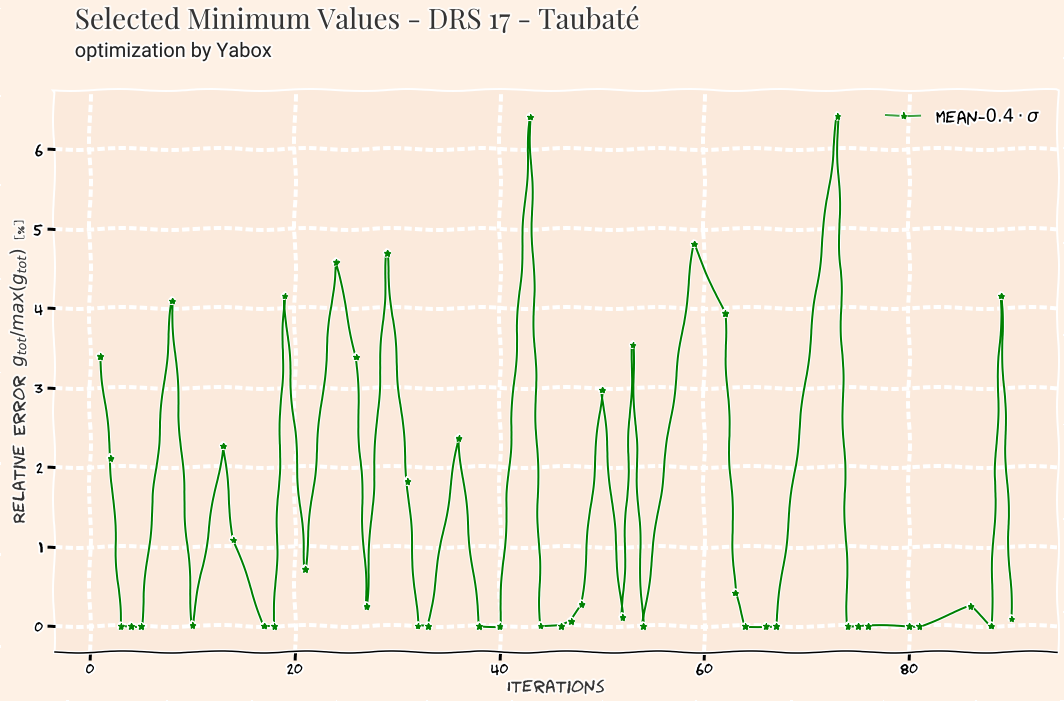

In [17]:
ggtot=[]
for districtRegion in DRS:
    versionStr=str(version)
    dateparse = lambda x: datetime.strptime(x, ' %Y-%m-%d')
    histOptAll= pd.read_table('./results/history_'+districtRegion+versionStr+'.csv', sep=",", \
                                index_col=0, header=None, parse_dates=[3], date_parser=dateparse,
        names = ["districtRegion","gtot",\
            "s0","startdate","i0","d0","startNcases","wcases","wrec"])
    histOptAll = histOptAll[['gtot', 'startdate','startNcases','s0',"i0","d0","wcases","wrec"]]
        
    #clean data
    histOptAll=histOptAll.dropna(how='all')
    histOptAll.gtot=pd.to_numeric(histOptAll.gtot, errors='coerce')
    histOptAll = histOptAll.reset_index(drop=True)
    histOptAll = histOptAll[histOptAll.loc[:,"gtot"]<0.5e14]
    
    #format integers and decimal places
    histOptAll['d0'] = histOptAll['d0'].apply(lambda x: int(x+0.5))
    histOptAll['startNcases'] = histOptAll['startNcases'].apply(lambda x: int(x+0.5))
    histOptAll['s0'] = histOptAll['s0'].apply(lambda x: int(x+0.5))
    histOptAll['i0'] = histOptAll['i0'].apply(lambda x: int(x+0.5))
    histOptAll['wcases'] = histOptAll['wcases'].apply(lambda x: round(x,4))
    histOptAll['wrec'] = histOptAll['wrec'].apply(lambda x: round(x,4))
    
    #print optimum parameters
    histOpt=histOptAll[histOptAll.gtot==min(histOptAll.gtot)]
    histOpt=histOpt.head(1)
    display(Markdown("# Results for "+districtRegion+" District Region"))
    display(histOpt.iloc[:,0:8])
    histOpt.to_csv("data/vars_optimized_"+districtRegion+model+"HistMin.csv", sep=",", index=False)
        
    #current parameters
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    if len(parameters)>12:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,ratio,wcases,wrec,popEst = parameters
    else:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,ratio,wcases,wrec = parameters
    
    #query parameters
    j = query['index'].values[0]
    
    #define s0, i0 and d0
    dfparam.at[j, "s0"] = histOpt.s0
    dfparam['s0'] = dfparam['s0'].apply(lambda x: int(x+0.5))
    dfparam.at[j, "i0"] = histOpt.i0
    dfparam['i0'] = dfparam['i0'].apply(lambda x: int(x+0.5))
    dfparam.at[j, "d0"] = histOpt.d0
    dfparam.at[j, "START"] = histOpt.startNcases

    dfparam['a0'] = dfparam['a0'].apply(lambda x: int(x+0.5))
    dfparam['e0'] = dfparam['e0'].apply(lambda x: int(x+0.5))
    dfparam['r0'] = dfparam['r0'].apply(lambda x: int(x+0.5))
    dfparam['d0'] = dfparam['d0'].apply(lambda x: int(x+0.5))
    #define Start N Cases
    dfparam['START'] = dfparam['START'].apply(lambda x: int(x+0.5))
    #define date, wcases, wrec
    dfparam.at[j, "start-date"] = histOpt.startdate.dt.strftime('%Y-%m-%d').values[0]
    dfparam.at[j, "WCASES"] = histOpt.wcases
    dfparam.at[j, "WREC"] = histOpt.wrec
    
    #save new parameters
    dfparam.to_csv("data/param_optimized_"+model+"_HistMin.csv", sep=",", index=False)
    
    ggtot.append(histOpt.gtot.values[0])
    
    #prepare plotting
    color_bg = '#FEF1E5'
    # lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'
    plt.rc('font', size=14)
    
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font)
        plt.ylabel("Error in Objective Function", fontproperties=comic_font, alpha = .75)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        #PLOTTING itself
        x=histOptAll.index
        y=histOptAll.gtot
        ax.plot(x,y, label="gtot")
        display(Markdown("## 5 Lowest Results"))
        histMin=histOptAll.nsmallest(5, ['gtot']).sort_values('gtot').iloc[:,0:8]
        display(histMin)

        ax.scatter(histMin.index, histMin.gtot,label="5 lowest",c='green',marker='*',s=400)
        histOptAll.rolling(100).mean()['gtot'].plot(label="100th average")

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Initial Conditions Optimization - "+districtRegion,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=20)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/convergence_'+districtRegion+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        histMin=histOptAll.iloc[:,0:8]
        histMin.sort_index(inplace=True)
        
        histMin['error']=histMin.gtot/histMin.gtot.max()*100
        x=histMin.index[histMin.error<histMin.error.mean()-0.4*histMin.error.std()]
        y=histMin.error[histMin.error<histMin.error.mean()-0.4*histMin.error.std()]
                
        ax.plot(x, y, label="mean-$0.4 \cdot \sigma$",c='green',marker='*')
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font, alpha = .75)
        plt.ylabel("Relative Error $g_{tot}/max(g_{tot})$ [%]", fontproperties=comic_font, alpha = .75)

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Selected Minimum Values - "+districtRegion,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=20)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/minimumPoints_'+districtRegion+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()

In [18]:
display(Markdown("# Final Results for Initial Conditions"))
display(Markdown("## "+model+" optimization model"))

from IPython.display import display
from IPython.display import clear_output
from IPython.display import HTML

dfparam["gtot"] = pd.Series(ggtot)
dfparam['gtot'] = dfparam['gtot'].apply(lambda x: int(x+0.5))

gtot_min=dfparam.gtot.min()
gtot_max=dfparam.gtot.max()
gtot_range=gtot_max-gtot_min
gtot_mean=dfparam.gtot.mean()
gtot_std=dfparam.gtot.std()

gtot_high=(gtot_mean)/gtot_range
gtot_low=abs(gtot_mean-gtot_std)/gtot_range

s = dfparam.style.background_gradient(cmap='RdYlGn_r', axis=0,subset=['gtot'],low=gtot_low/2.74,high=gtot_high/100)
display(s)

# Final Results for Initial Conditions

## Yabox optimization model